In [10]:
%matplotlib inline
import os
from subprocess import check_call
from glob import glob
import importlib

import yaml
import re

import cftime
import xarray as xr
import numpy as np

import time

import project as P
import calc
import pop_regional_means as pop

os.environ['CARTOPY_USER_BACKGROUNDS'] = '/glade/work/mclong/cartopy-background-img'
USER = os.environ['USER']

In [11]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster
import dask

Nnodes = 4
processes = 18
project = 'NCGD0033'

cluster = PBSCluster(queue='regular',
                     cores = 18,
                     processes = processes,
                     memory = '100GB',          
                     project = project,
                     walltime = '04:00:00',
                     local_directory=f'/glade/scratch/{USER}/dask-tmp')
client = Client(cluster)
cluster.scale(processes*Nnodes)

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/distributed/bokeh/core.py:56: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [12]:
with open('collections.yml') as f:
    collection_spec = yaml.load(f)

with open('pop_variable_defs.yml') as f:
    pop_variable_defs = yaml.load(f)

config = 'coupled'
component = 'ocn'
stream = 'pop.h'
freq = 'monthly'

data_source_key = '_'.join(['data_sources',config,component,stream,freq])

variable_list = ['TEMP','SALT','CFC11','CFC12','IAGE',
                 'NO3','PO4','SiO3','DIC','DIC_ALT_CO2','O2','Fe',
                 'diatChl','spChl','diazChl','DENITRIF','NITRIF','diaz_Nfix',
                 'IRON_FLUX','FG_CO2','MOC']

rgn_variable_list = ['TEMP','SALT','O2','NO3','Fe',
                     'IRON_FLUX','FG_CO2','DENITRIF','NITRIF','diaz_Nfix',
                     'KAPPA_THIC','KAPPA_ISOP','Fe_RIV_FLUX']

ctrl_variable_list = ['ABIO_D14Cocn','O2','NO3','Fe','TEMP']

# year offset: a mean for the historical runs
ctrl_offset = 1850 - np.array([d_attrs['ctrl_year'] for d_attrs in data_sources['historical']]).mean().astype(int)


col = {d_src: {} for d_src in data_sources}

## Compute monthly climatologies over 1990s

In [13]:

kwargs = {'catalog': data_sources,
          'analysis_name': 'clm-1990s',
          'sel_kwargs': {'time':slice(f'{1990-ctrl_offset:04d}-01-01',f'{1999-ctrl_offset:04d}-12-31')},
          'operators': calc.compute_mon_climatology,
          'clobber': False,
          'file_format': 'nc'}

results = []
for data_source in ['ctrl',]:    
    for v in ctrl_variable_list:   
        res = dask.delayed(P.process_data_source,pure=True)(variable=v,
                                                            data_source=data_source,
                                                            **kwargs)
        results.append(res)
        #a = P.process_data_source(variable=v,data_source=data_source,**kwargs)

res = dask.compute(*results)
for r in res:
    col[r.data_source][r.variable] = r
col

{'ctrl': {'ABIO_D14Cocn': ctrl.000.clm-1990s.ABIO_D14Cocn,
  'O2': ctrl.000.clm-1990s.O2,
  'NO3': ctrl.000.clm-1990s.NO3,
  'Fe': ctrl.000.clm-1990s.Fe,
  'TEMP': ctrl.000.clm-1990s.TEMP},
 'historical': {},
 'historical_cmip5': {}}

In [14]:
kwargs = {'catalog': data_sources,
          'analysis_name': 'clm-1990s',
          'sel_kwargs': {'time':slice('1990-01-01','1999-12-31')},
          'operators': calc.compute_mon_climatology,
          'clobber': False,
          'file_format': 'nc'}

results = []
for data_source in ['historical_cmip5','historical',]:    
    for v in variable_list:   
        res = dask.delayed(P.process_data_source,pure=True)(variable=v,
                                                            data_source=data_source,
                                                            **kwargs)
        results.append(res)
        #a = P.process_data_source(variable=v,data_source=data_source,**kwargs)

res = dask.compute(*results)
for r in res:
    col[r.data_source][r.variable] = r
col

{'ctrl': {'ABIO_D14Cocn': ctrl.000.clm-1990s.ABIO_D14Cocn,
  'O2': ctrl.000.clm-1990s.O2,
  'NO3': ctrl.000.clm-1990s.NO3,
  'Fe': ctrl.000.clm-1990s.Fe,
  'TEMP': ctrl.000.clm-1990s.TEMP},
 'historical': {'TEMP': historical.000-004.clm-1990s.TEMP,
  'SALT': historical.000-004.clm-1990s.SALT,
  'CFC11': historical.000-004.clm-1990s.CFC11,
  'CFC12': historical.000-004.clm-1990s.CFC12,
  'IAGE': historical.000-004.clm-1990s.IAGE,
  'NO3': historical.000-004.clm-1990s.NO3,
  'PO4': historical.000-004.clm-1990s.PO4,
  'SiO3': historical.000-004.clm-1990s.SiO3,
  'DIC': historical.000-004.clm-1990s.DIC,
  'DIC_ALT_CO2': historical.000-004.clm-1990s.DIC_ALT_CO2,
  'O2': historical.000-004.clm-1990s.O2,
  'Fe': historical.000-004.clm-1990s.Fe,
  'diatChl': historical.000-004.clm-1990s.diatChl,
  'spChl': historical.000-004.clm-1990s.spChl,
  'diazChl': historical.000-004.clm-1990s.diazChl,
  'DENITRIF': historical.000-004.clm-1990s.DENITRIF,
  'NITRIF': historical.000-004.clm-1990s.NITRIF,
 

### add some "derived variables"

First define the methods and dependent variables for each derived variable

In [15]:
importlib.reload(P)
derived_var_defs = {'pCFC11': P.derived_var_definition(methods = P.derive_var_pCFC11,
                                                       vars_dependent = ['TEMP','SALT','CFC11']),                    
                    'sigma_theta': P.derived_var_definition(methods = P.derive_var_sigma_theta_from_PD,
                                                            vars_dependent = ['PD']),
                    'MLD': P.derived_var_definition(methods = P.derive_var_MLD,
                                                    vars_dependent = ['SALT','TEMP']),                    
                   }

Do the computation

In [16]:
results = []
for data_source in ['historical','historical_cmip5']:    
    for v,vardef in derived_var_defs.items():
        res = dask.delayed(P.process_data_source,pure=True)(variable=v,
                                                            data_source=data_source,
                                                            derived_var_def = vardef,                                                            
                                                            **kwargs)
        results.append(res)
        #a = P.process_data_source(variable=v,data_source=data_source,
        #                      derived_var_def = vardef,**kwargs)


res = dask.compute(*results)
    
for r in res:
    col[r.data_source][r.variable] = r
col

{'ctrl': {'ABIO_D14Cocn': ctrl.000.clm-1990s.ABIO_D14Cocn,
  'O2': ctrl.000.clm-1990s.O2,
  'NO3': ctrl.000.clm-1990s.NO3,
  'Fe': ctrl.000.clm-1990s.Fe,
  'TEMP': ctrl.000.clm-1990s.TEMP},
 'historical': {'TEMP': historical.000-004.clm-1990s.TEMP,
  'SALT': historical.000-004.clm-1990s.SALT,
  'CFC11': historical.000-004.clm-1990s.CFC11,
  'CFC12': historical.000-004.clm-1990s.CFC12,
  'IAGE': historical.000-004.clm-1990s.IAGE,
  'NO3': historical.000-004.clm-1990s.NO3,
  'PO4': historical.000-004.clm-1990s.PO4,
  'SiO3': historical.000-004.clm-1990s.SiO3,
  'DIC': historical.000-004.clm-1990s.DIC,
  'DIC_ALT_CO2': historical.000-004.clm-1990s.DIC_ALT_CO2,
  'O2': historical.000-004.clm-1990s.O2,
  'Fe': historical.000-004.clm-1990s.Fe,
  'diatChl': historical.000-004.clm-1990s.diatChl,
  'spChl': historical.000-004.clm-1990s.spChl,
  'diazChl': historical.000-004.clm-1990s.diazChl,
  'DENITRIF': historical.000-004.clm-1990s.DENITRIF,
  'NITRIF': historical.000-004.clm-1990s.NITRIF,
 

## Compute annual mean, regional mean timeseries over historical run

Compute the grid-dependent variables.

In [17]:
region_ts_kwargs = {}
for d_src in ['historical_cmip5','historical',]:
    d_attrs = data_sources[d_src]
    if isinstance(d_attrs,list):
        grid = d_attrs[0]['grid']
    else:
        grid = d_attrs['grid']
    grid_file = f'/glade/work/mclong/grids/{grid}.nc'

    with xr.open_mfdataset(grid_file,decode_coords=False,decode_times=False) as ds:
        rmask3d = pop.region_mask_diagnostics(ds)
        MASKED_AREA,MASKED_VOL = pop.make_masked_area_and_vol(ds,rmask3d,ignore_ssh=True)

    region_ts_kwargs[d_src] = {'MASKED_VOL': MASKED_VOL.compute(),
                               'MASKED_AREA': MASKED_AREA.compute()}         

In [18]:
rcol = {d_src: {} for d_src in data_sources}
results = []
for d_src in ['historical_cmip5','historical',]:    
    kwargs = {'catalog': data_sources,
              'analysis_name': 'ann-rgn',
              'operators': [pop.make_regional_timeseries,calc.compute_ann_mean],
              'operators_kwargs': [region_ts_kwargs[d_src],{}],
              'clobber': False,
              'file_format': 'zarr'}
    
    for v in rgn_variable_list:   
        res = dask.delayed(P.process_data_source,pure=True)(variable=v,
                                                            data_source=d_src,
                                                            **kwargs)
        results.append(res)
        #a = P.process_data_source(variable=v,data_source=d_src,**kwargs)

res = dask.compute(*results)
    
for r in res:
    rcol[r.data_source][r.variable] = r
rcol  

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:57428 remote=tcp://10.148.10.15:50933>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:57413 remote=tcp://10.148.10.15:50933>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:36985 remote=tcp://10.148.10.15:33103>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:36986 remote=tcp://10.148.10.15:33103>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:57417 remote=tcp://10.148.10.15:50933>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:57422 remote=tcp://10.148.10.15:50933>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:36987 remote=tcp://10.148.10.15:33103>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:57423 r

{'ctrl': {},
 'historical': {'TEMP': historical.000-004.ann-rgn.TEMP,
  'SALT': historical.000-004.ann-rgn.SALT,
  'O2': historical.000-004.ann-rgn.O2,
  'NO3': historical.000-004.ann-rgn.NO3,
  'Fe': historical.000-004.ann-rgn.Fe,
  'IRON_FLUX': historical.000-004.ann-rgn.IRON_FLUX,
  'FG_CO2': historical.000-004.ann-rgn.FG_CO2,
  'DENITRIF': historical.000-004.ann-rgn.DENITRIF,
  'NITRIF': historical.000-004.ann-rgn.NITRIF,
  'diaz_Nfix': historical.000-004.ann-rgn.diaz_Nfix,
  'KAPPA_THIC': historical.000-004.ann-rgn.KAPPA_THIC,
  'KAPPA_ISOP': historical.000-004.ann-rgn.KAPPA_ISOP,
  'Fe_RIV_FLUX': historical.000-004.ann-rgn.Fe_RIV_FLUX},
 'historical_cmip5': {'TEMP': historical_cmip5.000.ann-rgn.TEMP,
  'SALT': historical_cmip5.000.ann-rgn.SALT,
  'O2': historical_cmip5.000.ann-rgn.O2,
  'NO3': historical_cmip5.000.ann-rgn.NO3,
  'Fe': historical_cmip5.000.ann-rgn.Fe,
  'IRON_FLUX': historical_cmip5.000.ann-rgn.IRON_FLUX,
  'FG_CO2': historical_cmip5.000.ann-rgn.FG_CO2,
  'DENITRI

### Start working with the data!

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmocean

import plottools as pt
import plotting_functions as pf

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:57547 remote=tcp://10.148.10.15:50933>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:37119 remote=tcp://10.148.10.15:33103>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:57549 remote=tcp://10.148.10.15:50933>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:37121 remote=tcp://10.148.10.15:33103>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:57551 remote=tcp://10.148.10.15:50933>


### MOC

In [20]:
ds = calc.compute_ann_mean(calc.fix_time(col['historical']['MOC'].load())).mean('ens').compute()
ds2 = calc.compute_ann_mean(calc.fix_time(col['historical_cmip5']['MOC'].load())).mean('ens').compute()

MOC_glb = ds.MOC.isel(transport_reg=0,time=0).sum('moc_comp')
MOC_glb2 = ds2.MOC.isel(transport_reg=0,time=0).sum('moc_comp')

MOC_atl = ds.MOC.isel(transport_reg=1,time=0).sum('moc_comp')
MOC_atl2 = ds2.MOC.isel(transport_reg=1,time=0).sum('moc_comp')


MOC_pac = MOC_glb - MOC_atl
MOC_pac2 = MOC_glb2 - MOC_atl2
MOC_glb

<xarray.DataArray 'MOC' (moc_z: 61, lat_aux_grid: 395)>
array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  9.690008e-06,
         2.716097e-06,  1.400050e-08],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ..., -4.155785e-02,
        -3.836610e-02, -3.716725e-02],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ..., -1.558657e-01,
        -1.509057e-01, -1.492610e-01],
       ...,
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ..., -3.501064e-07,
        -3.501064e-07, -3.501064e-07],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ..., -1.848806e-07,
        -1.848806e-07, -1.848806e-07],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00]])
Coordinates:
  * lat_aux_grid  (lat_aux_grid) float64 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z         (moc_z) float64 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
    time          int64 1

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:37116 remote=tcp://10.148.10.15:33103>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.15:57544 remote=tcp://10.148.10.15:50933>


<Figure size 576x432 with 0 Axes>

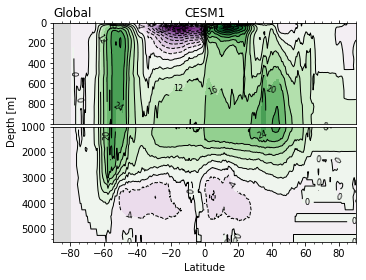

<Figure size 576x432 with 0 Axes>

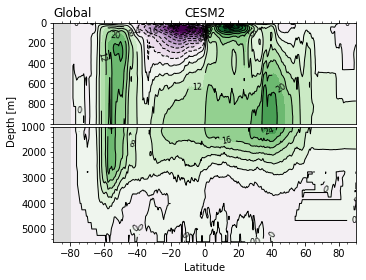

<Figure size 576x432 with 0 Axes>

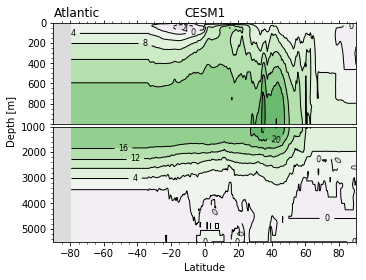

<Figure size 576x432 with 0 Axes>

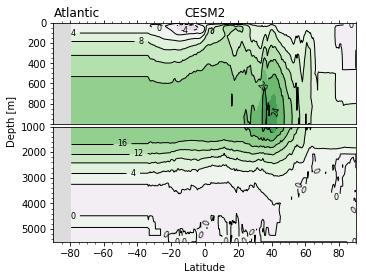

<Figure size 576x432 with 0 Axes>

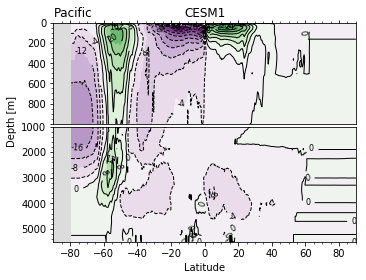

<Figure size 576x432 with 0 Axes>

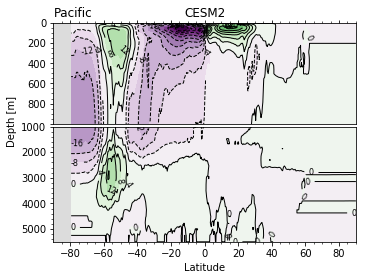

In [21]:
importlib.reload(pf)

plot_name = 'fig/MOC-global-cesm1.png'
pf.moc_plot(MOC_glb2,'Global','CESM1',plot_name=plot_name)

plot_name = 'fig/MOC-global-cesm2.png'
pf.moc_plot(MOC_glb,'Global','CESM2',plot_name=plot_name)

plot_name = 'fig/MOC-atlantic-cesm1.png'
pf.moc_plot(MOC_atl2,'Atlantic','CESM1',plot_name=plot_name)

plot_name = 'fig/MOC-atlantic-cesm2.png'
pf.moc_plot(MOC_atl,'Atlantic','CESM2',plot_name=plot_name)

plot_name = 'fig/MOC-pacific-cesm1.png'
pf.moc_plot(MOC_pac2,'Pacific','CESM1',plot_name=plot_name)

plot_name = 'fig/MOC-pacific-cesm2.png'
pf.moc_plot(MOC_pac,'Pacific','CESM2',plot_name=plot_name)

### Kappa profiles

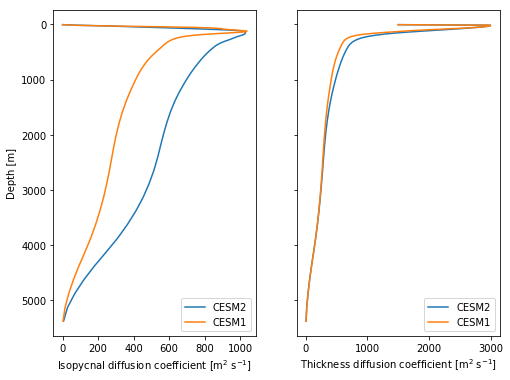

In [22]:
plot_name = 'fig/gm-kappa-profiles.png'

fig = plt.figure(figsize=(8,6))

cm2s_to_m2s = 1e-4

ax = fig.add_subplot(121)
ds = rcol['historical']['KAPPA_ISOP'].load().sel(region='90S-44S').mean(['ens','time']).compute()
ax.plot(ds.KAPPA_ISOP * cm2s_to_m2s, ds.z_t*1e-2,label = 'CESM2')

ds = rcol['historical_cmip5']['KAPPA_ISOP'].load().sel(region='90S-44S').mean(['ens','time']).compute()
ax.plot(ds.KAPPA_ISOP * cm2s_to_m2s, ds.z_t*1e-2,label = 'CESM1')

ax.legend()

ylm = ax.get_ylim()
ax.set_ylim(ylm[::-1])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Isopycnal diffusion coefficient [m$^2$ s$^{-1}$]')

ax = fig.add_subplot(122)
ds = rcol['historical']['KAPPA_THIC'].load().sel(region='90S-44S').mean(['ens','time']).compute()
ax.plot(ds.KAPPA_THIC * cm2s_to_m2s, ds.z_t*1e-2,label = 'CESM2')

ds = rcol['historical_cmip5']['KAPPA_THIC'].load().sel(region='90S-44S').mean(['ens','time']).compute()
ax.plot(ds.KAPPA_THIC * cm2s_to_m2s, ds.z_t*1e-2,label = 'CESM1')

ax.legend()

ax.set_yticklabels([])
ylm = ax.get_ylim()
ax.set_ylim(ylm[::-1])
ax.set_xlabel('Thickness diffusion coefficient [m$^2$ s$^{-1}$]')


plt.savefig(plot_name,dpi=300,bbox_inches='tight')


In [23]:
rcol['historical']['KAPPA_ISOP'].load().KAPPA_ISOP.attrs

OrderedDict([('cell_methods', 'time: mean'),
             ('long_name', 'Isopycnal diffusion coefficient'),
             ('units', 'cm^2/s')])

### plot N cycle imbalance

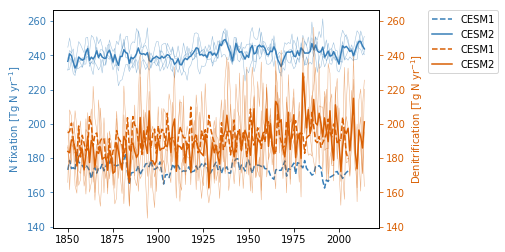

In [24]:
ds = rcol['historical']['diaz_Nfix'].load().isel(region=0)
ds = xr.merge((ds,rcol['historical']['DENITRIF'].load().isel(region=0)))

ds2 = rcol['historical_cmip5']['diaz_Nfix'].load().isel(region=0)
ds2 = xr.merge((ds2,rcol['historical_cmip5']['DENITRIF'].load().isel(region=0)))

fig = plt.figure()

#------------------------------------
axL = fig.add_subplot(111)
units = ds.diaz_Nfix.attrs['units']

for i in range(len(ds.ens)):
    plt.plot(ds.time,ds.diaz_Nfix[i,:],linewidth=0.5,color='#377eb8',alpha=0.5)
f2, = plt.plot(ds.time,ds.diaz_Nfix.mean('ens'),color='#377eb8',zorder=100)

f1, = plt.plot(ds2.time,ds2.diaz_Nfix.mean('ens'),linestyle='--',color='#377eb8',zorder=100)


axL.set_ylabel(f'N fixation [{units}]', color='#377eb8')
axL.tick_params('y', colors='#377eb8')
ylmL = axL.get_ylim()

#------------------------------------
axR = axL.twinx()
units = ds.DENITRIF.attrs['units']
for i in range(len(ds.ens)):
    plt.plot(ds.time,ds.DENITRIF[i,:],linewidth=0.5,color='#d95f02',alpha=0.5) #    
d2, = plt.plot(ds.time,ds.DENITRIF.mean('ens'),color='#d95f02',zorder=100)

d1, = plt.plot(ds2.time,ds2.DENITRIF.mean('ens'),linestyle='--',color='#d95f02',
         label = 'CESM1',
         zorder=100)

axR.set_ylabel(f'Denitrification [{units}]', color='#d95f02')
axR.tick_params('y', colors='#d95f02')
ylmR = axR.get_ylim()

ylm = [np.min([ylmL[0],ylmR[0]]),np.max([ylmL[-1],ylmR[-1]])]
axL.set_ylim(ylm)
axR.set_ylim(ylm)
plt.subplots_adjust(right=0.88)


plt.legend([f1,f2,d1,d2], ['CESM1','CESM2','CESM1','CESM2'],bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)

plt.savefig(f'fig/N-cycle-timeseries.pdf')


### get tracer data

In [25]:

for i,tracer in enumerate(['O2','NO3','TEMP']):
    ds_list = []
    for f in rcol['historical'][tracer].cache_locations:
        ds_list.append(xr.open_zarr(f,decode_times=False))    
    dsi = xr.concat(ds_list,dim='ens',data_vars=[f'{tracer}_avg',tracer])
    if i == 0:
        ds = dsi
    else:
        ds = xr.merge((ds,dsi))

    ds_list = []
    for f in rcol['historical_cmip5'][tracer].cache_locations:
        ds_list.append(xr.open_zarr(f,decode_times=False))    
    dsi = xr.concat(ds_list,dim='ens',data_vars=[f'{tracer}_avg',tracer])
    if i == 0:
        ds2 = dsi
    else:
        ds2 = xr.merge((ds2,dsi))
ds = ds.compute()
ds2 = ds2.compute()

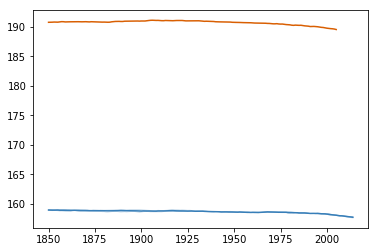

In [26]:
fig = plt.figure()

#------------------------------------
ax = fig.add_subplot(111)

for i in range(len(ds.ens)):
    plt.plot(ds.time,ds.O2_avg[i,:],linewidth=0.5,color='#377eb8',alpha=0.5)
plt.plot(ds.time,ds.O2_avg.mean('ens'),color='#377eb8',zorder=100)
plt.plot(ds2.time,ds2.O2_avg.mean('ens'),color='#d95f02',zorder=100)

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


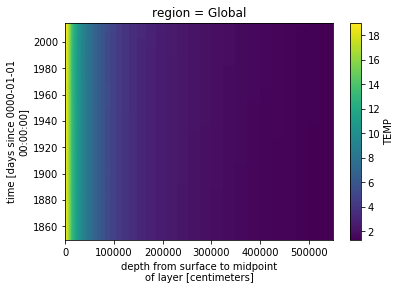

In [27]:
ds.TEMP.mean('ens').isel(region=0).plot()

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


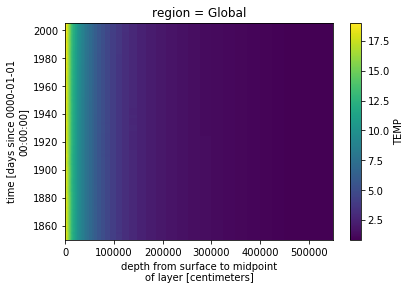

In [28]:
ds2.TEMP.mean('ens').isel(region=0).plot()

### pCFC-11 zonal mean biases

In [29]:
obs = xr.open_dataset('/glade/p_old/work/mclong/GLODAP/za_pCFC11_pCFC12_gx1v6.nc')
obs

<xarray.Dataset>
Dimensions:  (basins: 4, lat_t: 394, z_t: 60)
Coordinates:
  * basins   (basins) float64 0.5 1.5 2.5 3.5
  * lat_t    (lat_t) float32 -79.22052 -78.68631 ... 89.370575 89.904816
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
Data variables:
    pCFC11   (basins, z_t, lat_t) float32 ...
    pCFC12   (basins, z_t, lat_t) float32 ...
Attributes:
    history:  Tue Jan 22 21:37:49 2013: ncks -A za_pCFC12_gx1v6.nc pCFC11_pCF...
    NCO:      4.1.0

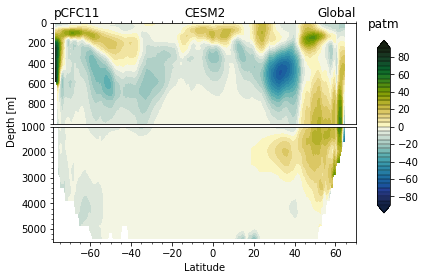

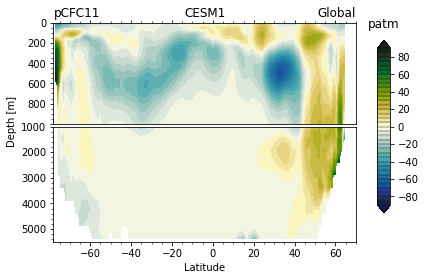

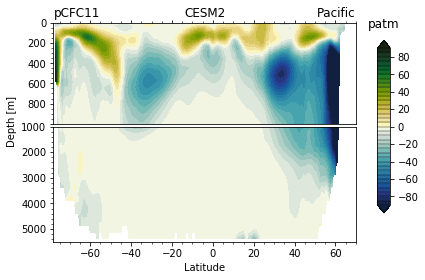

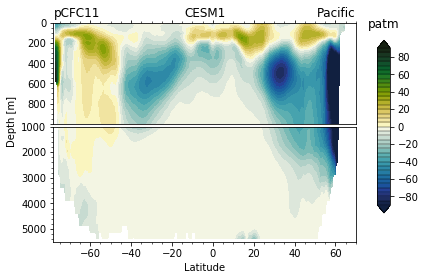

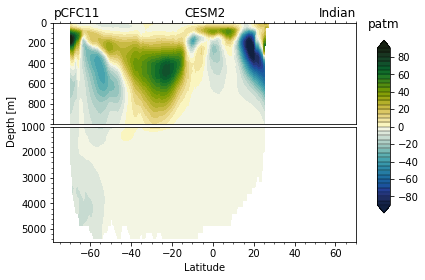

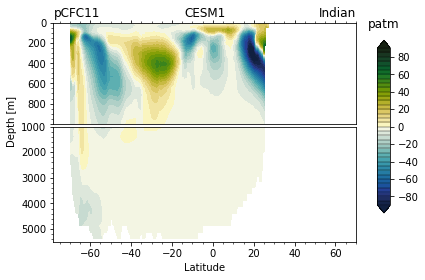

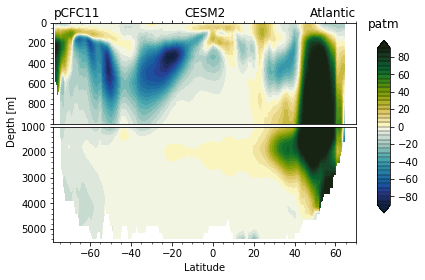

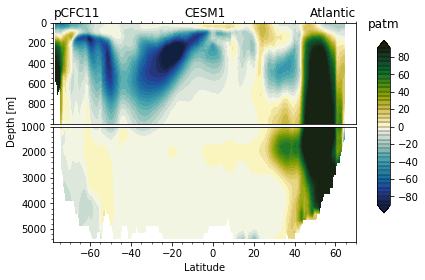

In [30]:
importlib.reload(pf)
v = 'pCFC11'
basins = ['Global','Pacific','Indian','Atlantic']
model_name = {'historical':'CESM2','historical_cmip5':'CESM1'}
for i,basin in enumerate(basins):
    for col_name,col_info in col.items():
        if v in col_info:
            center_str = model_name[col_name]
            plot_name = f'fig/{v}.bias-section.{basin}.{col_name}.pdf'
            ds = col_info[v].load(option='za')
            lat = ds.lat_t
            z_t = ds.z_t
            bias = ds[v].isel(basins=i).mean(['ens','time']).compute() 
            bias = bias - obs.pCFC11.isel(basins=0)
            pf.plot_cfc_bias_section(lat,z_t,bias,
                                     left_str=v,
                                     center_str=center_str,
                                     right_str=basin,
                                     plot_name=plot_name)

### Time-evolution of `IRON_FLUX`

In [31]:
ds = rcol['historical']['IRON_FLUX'].load().compute()
ds2 = rcol['historical_cmip5']['IRON_FLUX'].load().compute()

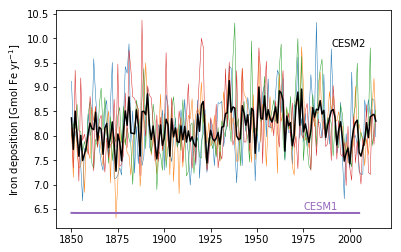

In [32]:
plot_name = f'fig/IRON_FLUX.timeseries.global.pdf'

fig = plt.figure()
ax = fig.add_subplot(111)
for ens_i in range(len(ds.ens)):
    ax.plot(ds.time,ds.IRON_FLUX.isel(region=0,ens=ens_i),linewidth=0.5)
ax.plot(ds.time,ds.IRON_FLUX.isel(region=0).mean('ens'),color='k',linewidth=1.5)
ax.set_ylabel('Iron deposition [Gmol Fe yr$^{-1}$]')

p = ax.plot(ds2.time,ds2.IRON_FLUX.isel(region=0,ens=0),linewidth=2)

ax.text(1990,ds.IRON_FLUX.isel(region=0).sel(time=1990).max('ens')*1.005,
        'CESM2',color='k')

ax.text(1975,ds2.IRON_FLUX.isel(region=0,ens=0).sel(time=1975)*1.01,
        'CESM1',color=p[0].get_color())

plt.savefig(plot_name,dpi=300,bbox_inches='tight')

## MLD biases

In [33]:
#/glade/work/mclong/woa2013v2/derived/POP_gx1v6/mld_mon_1x1d_to_gx1v6.nc
obs = xr.open_dataset('/glade/work/mclong/woa2013v2/derived/POP_gx1v7/mld_mon_RG_1x1d_to_gx1v7.nc',
                      decode_coords = False,
                      decode_times = False)
obs = obs.isel(time=8)
obs

<xarray.Dataset>
Dimensions:               (lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
    time                  float64 15.0
  * z_t                   (z_t) float32 500.0 1500.0 ... 512502.8 537500.0
  * z_w                   (z_w) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
  * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
  * moc_z                 (moc_z) float32 0.0 1000.0 ... 525000.94 549999.06
  * z_t_150m              (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w_bot               (z_w_bot) float32 1000.0 2000.0 ... 549999.06
  * z_w_top               (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
Dimensions without coordinates: moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables:
    MLD                   (nlat, nlon) float64 ...
    ANGLE                 (nlat, nlon) float64 ...
  

In [34]:
keep_vars = ['MLD','TLONG','TLAT']
ds = col['historical']['MLD'].load()
ds = ds.drop([v for v in ds.variables if v not in keep_vars]).isel(time=8)
ds = ds.mean('ens').compute()

ds2 = col['historical_cmip5']['MLD'].load()
ds2 = ds2.drop([v for v in ds2.variables if v not in keep_vars]).isel(time=8).compute()
ds2 = ds2.mean('ens').compute()

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [35]:
bias = xr.Dataset()
bias['MLD'] = ds.MLD - obs.MLD

bias2 = xr.Dataset()
bias2['MLD'] = ds2.MLD - obs.MLD
bias2

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Coordinates:
    time     float64 15.0
Dimensions without coordinates: nlat, nlon
Data variables:
    MLD      (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [36]:
import pandas as pd
def orsi_fronts():
    fronts = {}
    for f in ['STF','SAF','PF','SACCF','SBDY']:
        fronts[f] = pd.read_table(f'data/fronts/{f.lower()}.txt',sep='\s+',names=['lon','lat'],
                                  comment='%')
    return fronts

fronts = orsi_fronts()

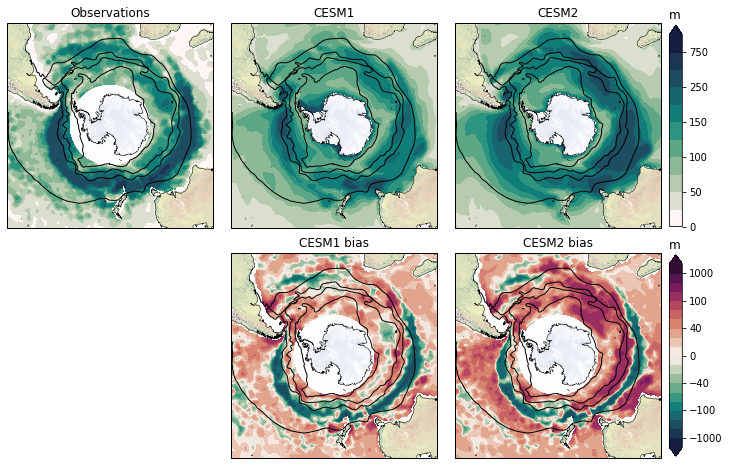

In [37]:
plot_name = f'fig/MLD-southern-ocean-sep.png'

mld_levels = np.array([0,25,50,75,100,125,150,200,250,500,750.,1000])
bias_levels = np.array([-4500,-1000,-500,-200,-100,-80,-60,-40,-20,-10,0,10,20,40,60,80,100,200,500,1000,2500])

mld_norm = colors.BoundaryNorm(mld_levels,256)
bias_norm = colors.BoundaryNorm(bias_levels,256)

mld_cmap = cmocean.cm.tempo
bias_cmap = cmocean.cm.curl

test_layout = False

fig = plt.figure(figsize=(12,8))
axs = []

#---------------------------------------------
ax = fig.add_subplot(2,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.background_img('natural-earth-1-no-ocean',resolution='large4096px')

lon,lat,field = pt.adjust_pop_grid(obs.TLONG.values,obs.TLAT.values,obs.MLD.values)
if test_layout: field[:] = 0.
cf1 = ax.contourf(lon, lat, field,
                  levels = mld_levels,
                  norm = mld_norm,
                  cmap = mld_cmap,
                  extend = 'max',
                  transform=ccrs.PlateCarree())


ax.coastlines('50m',linewidth=0.5,zorder=10)
ax.set_title('Observations')


for f,df in fronts.items():
    if f == 'SACCF': continue
    lon = df.lon.values
    lat = df.lat.values
    lon = np.append(lon,lon[0]+360)
    lat = np.append(lat,lat[0])
    ax.plot(lon,lat,transform=ccrs.PlateCarree(),label=f,color='k',linewidth=1.)

axs.append(ax)

#---------------------------------------------
ax = fig.add_subplot(2,3,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.background_img('natural-earth-1-no-ocean',resolution='large4096px')

lon,lat,field = pt.adjust_pop_grid(ds2.TLONG.values,ds2.TLAT.values,ds2.MLD.values)
if test_layout: field[:] = 0.
cf2 = ax.contourf(lon, lat, field,
                  levels = mld_levels,
                  norm = mld_norm,
                  cmap = mld_cmap,
                  extend = 'max',
                  transform=ccrs.PlateCarree())


ax.coastlines('50m',linewidth=0.5,zorder=10)
ax.set_title('CESM1')

for f,df in fronts.items():
    if f == 'SACCF': continue
    lon = df.lon.values
    lat = df.lat.values
    lon = np.append(lon,lon[0]+360)
    lat = np.append(lat,lat[0])
    ax.plot(lon,lat,transform=ccrs.PlateCarree(),label=f,color='k',linewidth=1.)
    
axs.append(ax)

#---------------------------------------------
ax = fig.add_subplot(2,3,3, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.background_img('natural-earth-1-no-ocean',resolution='large4096px')

lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,ds.MLD.values)
if test_layout: field[:] = 0.
cf3 = ax.contourf(lon, lat, field,
                  levels = mld_levels,
                  norm = mld_norm,
                  cmap = mld_cmap,
                  extend = 'max',
                  transform=ccrs.PlateCarree())

ax.coastlines('50m',linewidth=0.5,zorder=10)
ax.set_title('CESM2')

for f,df in fronts.items():
    if f == 'SACCF': continue
    lon = df.lon.values
    lat = df.lat.values
    lon = np.append(lon,lon[0]+360)
    lat = np.append(lat,lat[0])
    ax.plot(lon,lat,transform=ccrs.PlateCarree(),label=f,color='k',linewidth=1.)
    
axs.append(ax)

#---------------------------------------------
ax = fig.add_subplot(2,3,5, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.background_img('natural-earth-1-no-ocean',resolution='large4096px')

lon,lat,field = pt.adjust_pop_grid(ds2.TLONG.values,ds2.TLAT.values,bias2.MLD.values)
if test_layout: field[:] = 0.
cf4 = ax.contourf(lon, lat, field,
                  levels = bias_levels,
                  norm = bias_norm,
                  cmap = bias_cmap,
                  extend = 'both',
                  transform=ccrs.PlateCarree())

ax.coastlines('50m',linewidth=0.5,zorder=10)
ax.set_title('CESM1 bias')

for f,df in fronts.items():
    if f == 'SACCF': continue
    lon = df.lon.values
    lat = df.lat.values
    lon = np.append(lon,lon[0]+360)
    lat = np.append(lat,lat[0])
    ax.plot(lon,lat,transform=ccrs.PlateCarree(),label=f,color='k',linewidth=1.)
    
axs.append(ax)

#---------------------------------------------
ax = fig.add_subplot(2,3,6, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.background_img('natural-earth-1-no-ocean',resolution='large4096px')

lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,bias.MLD.values)
if test_layout: field[:] = 0.
cf5 = ax.contourf(lon, lat, field,
                  levels = bias_levels, 
                  norm = bias_norm,
                  cmap = bias_cmap,
                  extend = 'both',
                  transform=ccrs.PlateCarree())

ax.coastlines('50m',linewidth=0.5,zorder=10)
ax.set_title('CESM2 bias')

for f,df in fronts.items():
    if f == 'SACCF': continue
    lon = df.lon.values
    lat = df.lat.values
    lon = np.append(lon,lon[0]+360)
    lat = np.append(lat,lat[0])
    ax.plot(lon,lat,transform=ccrs.PlateCarree(),label=f,color='k',linewidth=1.)
    
axs.append(ax)

#---------------------------------------------
plt.subplots_adjust(right=0.9,hspace=0.12,wspace=0.01)

ptop = axs[0].get_position()
pbot = axs[2].get_position()

height = ptop.y0 + ptop.height - pbot.y0
cbar_height = 0.35
y0 = pbot.y0+height/2-cbar_height/2 
x0 = pbot.x0 + pbot.width + 0.01
cax = plt.axes((x0,y0,0.015,cbar_height))
cax.set_title('m',loc='left')
plt.colorbar(cf1,cax=cax)    


ptop = axs[-1].get_position()
pbot = axs[-1].get_position()

height = ptop.y0 + ptop.height - pbot.y0
cbar_height = 0.35
y0 = pbot.y0+height/2-cbar_height/2 
x0 = pbot.x0 + pbot.width + 0.01
cax = plt.axes((x0,y0,0.015,cbar_height))
cax.set_title('m',loc='left')
plt.colorbar(cf5,cax=cax)    


fig.savefig(plot_name,dpi=300,bbox_inches='tight')